# Programming Exercise 3: Multi-class Classification and Neural Networks

> In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.

## 1. Multi-class Classification

> For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.
In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.

### 1.1 Dataset

> You are given a data set in ex3data1.mat that contains 5000 training examples of handwritten digits,  where each training example is a 20 pixel by 20 pixel grayscale image of the digit.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy.io
mat = scipy.io.loadmat('data/ex3data1.mat')
mat

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

### 1.2 Visualizing the Data

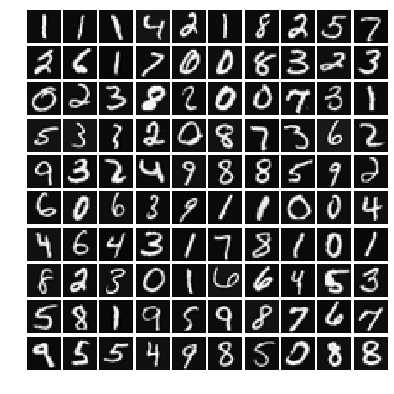

In [3]:
import numpy as np
rows = 10
cols = 10
fig = plt.figure(figsize=(5,5))
indexes = np.random.choice(5000, rows*cols)
count = 0
for i in range(0,rows):
    for j in range(0,cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(mat['X'][indexes[count]].reshape(20,20).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()

### 1.3 Vectorizing Logistic Regression

#### 1.3.1 Vectorizing Regularized Logistic Regression

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^m[y^i log(h_\theta(x^i))+(1-y^i)log(1-h_\theta(x^i))] + \frac{\lambda}{2m} \sum_{j=1}^n\theta_j^2$$

Gradient:

$$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)} - y^{(i)})\cdot x_j^{(i)} \ \text{for j=0}$$

$$\frac{\partial J(\theta)}{\partial \theta_0} = (\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)} - y^{(i)})\cdot x_j^{(i)}) + \frac{\lambda}{m}\theta_j \ \text{for j$\ge$1}$$

Recall that:

$h_\theta(x^{(i)}) = g(\theta^Tx^{(i)})$

$g(z) = \frac{1}{1+e^{-z}}$


In [5]:
import numpy as np
def sigmoid(z):
    z = np.array(z)
    return 1 / (1+np.exp(-z))

In [6]:
def lr_cost_function(theta, X, y, lambda_reg):
    m = y.shape[0]
    theta = theta[:, np.newaxis] 
    h = sigmoid(X.dot(theta))
    J = (1/m) * (-y.T.dot(np.log(h)) - (1-y).T.dot(np.log(1-h))) + (lambda_reg/(2*m)) * np.sum(theta[1:]**2)

    diff_hy = h - y
    grad = (1/m) * diff_hy.T.dot(X) + ((lambda_reg/m) * theta.T)
    grad[0, 0] = (1/m) * diff_hy.T.dot(X[:, 0])

    return J, grad

Testing Cost Function

In [7]:
theta_t = np.array([-2, -1, 1, 2])
X_t = np.hstack((np.ones((5,1)), (np.arange(1,16).reshape(3,5)).T / 10))
y_t = np.array([1, 0, 1, 0, 1]).reshape(5, -1)
lambda_t = 3

In [8]:
J, grad = lr_cost_function(theta_t, X_t, y_t, lambda_t)
print('Cost:', J)
print('Expected cost: 2.534819')
print('Gradients:')
print(grad.T)
print('Expected gradients:')
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003')

Cost: [[ 2.5348194]]
Expected cost: 2.534819
Gradients:
[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


### 1.4 One-vs-all Classification

> In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K = 10$, but your code should work for any value of K.

In [9]:
import scipy.optimize as opt
def one_vs_all(X, y, num_labels, lambda_reg):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n+1))    
    X = np.hstack((np.ones((m,1)), X))
    
    for i in range(num_labels):
        initial_theta = np.zeros(shape=(n+1))
        opt_results = opt.minimize(lr_cost_function, initial_theta, args=(X, y==i+1, lambda_reg), 
                                   method='TNC', jac=True, options={'maxiter':50})
        all_theta[i, :] = opt_results['x']
        
    return all_theta

#### 1.4.1 One-vs-all Prediction

In [10]:
def predict_one_vs_all(all_theta, X):
    m, n = X.shape
    X = np.hstack((np.ones((m,1)),X))
    
    pred = sigmoid(X.dot(all_theta.T))
    y_pred = np.argmax(pred, axis=1)+1
    return y_pred

In [11]:
lambda_r = 0.1
num_labels = 10
all_theta = one_vs_all(mat['X'], mat['y'], num_labels, lambda_r)

In [12]:
y_pred = predict_one_vs_all(all_theta, mat['X'])
accuracy = np.mean(y_pred == mat['y'].T)
f'Train accuracy: {accuracy * 100}'

'Train accuracy: 95.39999999999999'

#### 1.4.2 Similar Code using Scikit-Learn:

In [13]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='newton-cg', max_iter=50, multi_class='ovr')
log_reg.fit(mat['X'], mat['y'].T[0])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=None,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
log_reg.score(mat['X'], mat['y'].T[0])

0.9446

## 2. Neural Networks

> In this part of the exercise, you will implement a neural network to rec- ognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s ex- ercise, you will write the backpropagation algorithm for learning the neural network parameters.

### 2.1 Model Representation

<img src="neural_network.png">

> You have been provided with a set of network parameters $(\Theta^{(1)},\Theta^{(2)})$ already trained by us.

In [15]:
mat_weights = scipy.io.loadmat('data/ex3weights.mat')

In [17]:
mat_weights['Theta1'].shape, mat_weights['Theta2'].shape

((25, 401), (10, 26))

### 2.2 Feedforward Propagation and Prediction

The formulas to find $h_\theta(x^{(i)})$ are in the neural network figure above.

In [20]:
def predict_nn(theta1, theta2, X):
    m, n = X.shape
    a1 = np.hstack((np.ones((m,1)),X)) #with a0
    
    z2 = a1.dot(theta1.T)
    a2 = sigmoid(z2)
    
    z3 = np.hstack((np.ones((m,1)),a2)).dot(theta2.T) #with a0
    a3 = sigmoid(z3)
    h = np.argmax(a3, axis=1)+1 #get label with largest h(x)
    
    return h

In [21]:
y_pred = predict_nn(mat_weights['Theta1'], mat_weights['Theta2'], mat['X'])
accuracy = np.mean(y_pred == mat['y'].T)
f'Train accuracy: {accuracy * 100}'

'Train accuracy: 97.52'

### 2.2.1 Similar Code using Scikit-Learn:

In [22]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(25,), activation='logistic')
nn.fit(mat['X'], mat['y'].T[0])

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(25,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [23]:
nn.score(mat['X'], mat['y'].T[0])

0.98760000000000003